# STAT 551
# Man Chong (Henry) Leong
# Spatial Joining Using R - Point vs Point and Point vs Polygon

## Goal
Distribute weather stations from NC and adjacent states to the population centroids of 2010 Census Tracts in NC based on the closest distance. (Point to point)

Also, we will show how to join point to polygen.

# Data
+ Census Boundary of 2010 Census Tracts in NC (Polygon)
+ Lists of weather stations in NC, GA, SC, TN and VA (Point)
+ Population Centroid for 2010 Census Tract in NC (Point)

In [1]:
library("sp")
library("rgdal")
library("dplyr")
library("tidyr")
library("raster")
library("data.table")
library("ggplot2")
library("broom")

rgdal: version: 1.3-2, (SVN revision 755)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/proj
 Linking to sp version: 1.3-1 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘raster’

The following object is masked from ‘package:tidyr’:

    extract

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘data.table’

The following object is masked from ‘package:raster’:

    shift

The following objects are 

Load all the nesessary packages. "sp", "rgdal" are widely used in R for spatial statistics.

### Import needed files

In [2]:
# shape file, which contains information for polygon
NC2010Trt <- rgdal::readOGR(".", 
                     layer = "2010_Census_trct")
# extract the Coordinate Reference Systems
NC2010Trt.crs <- sp::CRS(sp::proj4string(NC2010Trt))

OGR data source with driver: ESRI Shapefile 
Source: "/Users/manchongleong/Documents/GitHub/STAT551", layer: "2010_Census_trct"
with 2195 features
It has 57 fields
Integer64 fields read as strings:  ALAND10 AWATER10 


Read shape file into R. Usually, it represents the "shape" of the class. And sometimes, it comes with a data table (data frame), which is a .dbf file with the same name of the shape file. However, the limitation for the data table (data frame) comes with shape file is 2GB. 

Also, a layer usually contains 4 files. Their formats including .shp, .shx, .dbf, and .prj.

Coordinate Reference Systems (CRS) is used to project spatial data. With different CRS, we might get different results.


Regions defined for each Polygons


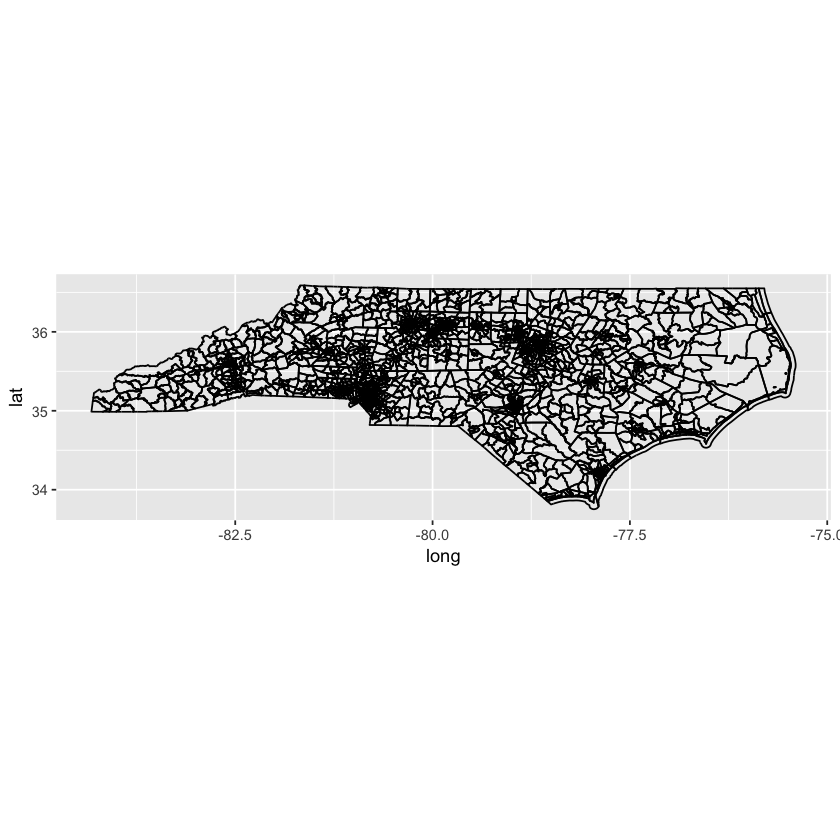

In [3]:
# convert a spatial object into data.frame
NC2010Trt.points = broom::tidy(NC2010Trt)

map_NC2010_trt <- ggplot() + 
  #geom_polygon() +
  geom_path(data=NC2010Trt.points, aes(long,lat,group=group), color="black") +
  coord_equal() 

map_NC2010_trt


Before making a map by using `ggplot`, the spatial object has to be converted to a dataframe first!

In [4]:
head CenPop2010_Mean_TR37.txt

STATEFP,COUNTYFP,TRACTCE,POPULATION,LATITUDE,LONGITUDE
37,001,020100,3908,+36.093222,-079.446300
37,001,020200,4152,+36.093270,-079.420799
37,001,020300,8063,+36.098388,-079.398934
37,001,020400,6059,+36.114582,-079.430586
37,001,020501,3575,+36.113958,-079.476588
37,001,020502,3782,+36.111115,-079.449398
37,001,020601,3234,+36.088531,-079.482010
37,001,020602,2414,+36.097635,-079.461676
37,001,020701,4519,+36.071156,-079.481592


In [6]:
head list_station_NC_surrounding.csv

USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END,combine_USAF_WBAN
692704,99999,MPRC-FT STEWART,US,GA,KQRC,+32.033,-081.667,+0018.0,19850125,20091215,69270499999
720120,63837,HILTON HEAD AIRPORT,US,SC,KHXD,+32.217,-080.700,+0007.3,20060101,20180620,72012063837
720120,99999,HILTON HEAD,US,SC,KHXD,+32.217,-080.700,+0006.0,20040904,20071231,72012099999
720168,99999,COVINGTON MUNI,US,TN,KM04,+35.583,-089.587,+0085.3,20170427,20180619,72016899999
720171,99999,WILLIAM L WHITEHURST FLD,US,TN,KM08,+35.214,-089.043,+0152.1,20160804,20180619,72017199999
720257,63835,EARLY COUNTY AIRPORT,US,GA,KBIJ,+31.397,-084.895,+0065.2,20060101,20180620,72025763835
720257,99999,EARLY CO,US,GA,KBIJ,+31.400,-084.900,+0065.0,20040525,20071231,72025799999
720263,63834,ELBERT CO-PATZ FLD AIRPORT,US,GA,K27A,+34.095,-082.816,+0183.8,20171004,20180620,72026363834
720263,99999,ELBERT CO PATZ FLD,US,GA,,+34.095,-082.816,+0183.8,20040525,20180322,72026399999


In [5]:
# population Centroid
NC_cen_cty <- data.table::fread("CenPop2010_Mean_TR37.txt", 
                                colClasses = c(STATEFP = "character", 
                                               COUNTYFP = "character", 
                                               TRACTCE = "character"))

# list of weather station in NC
NC_station <- data.table::fread("./list_station_NC.csv") %>% 
  tidyr::drop_na(LON, LAT)

# list of weather station in GA, SC, TN and VA
NC_surrounding_station <- data.table::fread("./list_station_NC_surrounding.csv") %>% 
  tidyr::drop_na(LON, LAT)



Unfortunately, R and Python aren't smart like us! They don't know some identifiers such as FIPS codes are not integer! These identifiers sometimes start with "0" (i.e. `001`), and will be truncated into `1` if it is read as integer. 

In order to avoid bugs, we better specify the type first.

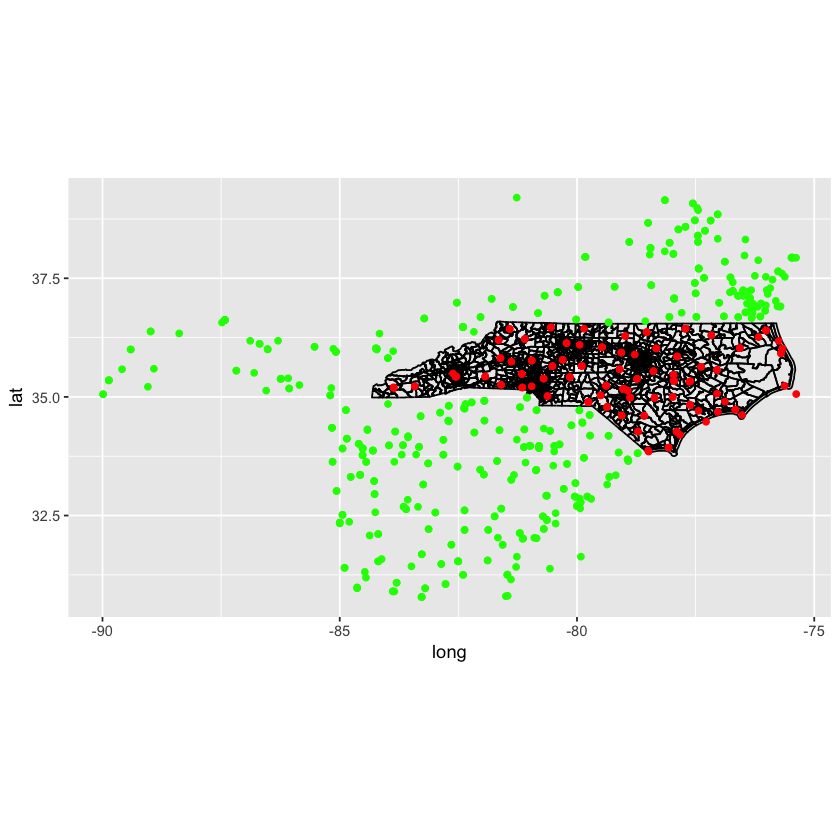

In [7]:
map_NC2010_trt_point <- map_NC2010_trt +
  geom_point(data=NC_station, aes(LON, LAT), color="red") +
  geom_point(data=NC_surrounding_station, aes(LON, LAT), color="green")

map_NC2010_trt_point


### Get Longitude and Latitude for each import files

In [8]:
xy_NC_cen_cty <- NC_cen_cty[, c("LONGITUDE", "LATITUDE")]
xy_NC_station <- NC_station[, c("LON", "LAT")]
xy_NC_surrounding_station <- NC_surrounding_station[, 
                                                    c("LON", "LAT")]

This step is to get the latitude and longitude, which will be used for defining a spatial object.

### Define spatial object based on the import datasets

In [9]:
# using the same CRS with the 2010 NC Tracts
spdf_NC_cen_cty <- sp::SpatialPointsDataFrame(coords = xy_NC_cen_cty, 
                                          data = NC_cen_cty, proj4string = NC2010Trt.crs)
# project the spatial object
new_CRS <- "+proj=lcc +lat_1=34.33333333333334 +lat_2=36.16666666666666 +lat_0=33.75 +lon_0=-79 +x_0=609601.22 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"
spdf_NC_cen_cty_pj <- sp::spTransform(spdf_NC_cen_cty, 
                                      sp::CRS(new_CRS))


For defining a spatial object, we need the following components:
+ data
+ Coordinate
+ proj4string, which represents CRS

We can always project a spatial object based on one CRS to another CRS! As long as we have a target CRS.

In [10]:
# using the same CRS with the 2010 NC Tracts
spdf_NC_station <- sp::SpatialPointsDataFrame(coords = xy_NC_station, 
                                          data = NC_station, proj4string = NC2010Trt.crs)
# project the spatial object
spdf_NC_station_pj <- sp::spTransform(spdf_NC_station, 
                                      sp::CRS(new_CRS))

# using the same CRS with the 2010 NC Tracts
spdf_NC_surrounding_station <- sp::SpatialPointsDataFrame(coords = xy_NC_surrounding_station, 
                                                      data = NC_surrounding_station, 
                                                          proj4string = NC2010Trt.crs)
# project the spatial object
spdf_NC_surrounding_station_pj <- sp::spTransform(spdf_NC_surrounding_station, 
                                                  sp::CRS(new_CRS))


Before doing spatial join, we need to make sure one thing. The target and feature are at the same CRS! Otherwise, the result can be surprising!

### Data processing and merging

In [11]:
# select the columns we need
NC_station_clean <- NC_station %>% dplyr::select("CTRY", 
                                                 "LAT", 
                                                 "LON", 
                                                 "STATE", 
                                                 "STATION NAME", 
                                                 "USAF", # Air Force Station ID
                                                 "WBAN", # Weather-Bureau-Army-Navy
                                                 "combine_USAF_WBAN") %>%
  dplyr::mutate(combine_USAF_WBAN = as.character(combine_USAF_WBAN)) # make sure it's not int

NC_surrounding_station_clean <- NC_surrounding_station %>% 
  dplyr::select("CTRY", "LAT", "LON", "STATE", "STATION NAME", 
                "USAF", "WBAN", "combine_USAF_WBAN") %>%
  dplyr::mutate(combine_USAF_WBAN = as.character(combine_USAF_WBAN)) # make sure it's not int

# union the stations in NC and the stations in GA, SC, TN and VA
merge_station_clean <- rbind(NC_station_clean, NC_surrounding_station_clean)

# get lon, lat
xy_merge_station_clean <- merge_station_clean[, c("LON", 
                                                  "LAT")]
# define spatial object, using the same CRS with the 2010 NC Tracts
spdf_merge_station_clean <- sp::SpatialPointsDataFrame(coords = xy_merge_station_clean, 
                                                   data = merge_station_clean, 
                                                       proj4string = NC2010Trt.crs)
# project the spatial object
spdf_merge_station_clean_pj <- sp::spTransform(spdf_merge_station_clean, 
                                           sp::CRS(new_CRS))


In [12]:
# calculate distance between points
distance_station_cen <- rgeos::gDistance(spdf_merge_station_clean_pj, 
                                  spdf_NC_cen_cty_pj, byid = T)

# get the index of station from the distance matrix
index_crt_station <- apply(distance_station_cen, 1, 
                           which.min)

# merge the result of cloest station index back to the target dataframe
merge_weather_station_crt <- cbind(NC_cen_cty, index_crt_station) %>%
  mutate(index_crt_station=as.character(index_crt_station))

# for joining purpose
merge_station_clean$row_number <- row.names(merge_station_clean)



In [13]:
census_trt_join_station <- left_join(merge_weather_station_crt, 
                                     merge_station_clean, 
                                     by = c("index_crt_station"= "row_number")
                                    )

In [14]:
head(census_trt_join_station)

STATEFP,COUNTYFP,TRACTCE,POPULATION,LATITUDE,LONGITUDE,index_crt_station,CTRY,LAT,LON,STATE,STATION NAME,USAF,WBAN,combine_USAF_WBAN
37,001,020100,3908,36.09322,-79.44630,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999
37,001,020200,4152,36.09327,-79.42080,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999
37,001,020300,8063,36.09839,-79.39893,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999
37,001,020400,6059,36.11458,-79.43059,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999
37,001,020501,3575,36.11396,-79.47659,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999
37,001,020502,3782,36.11111,-79.44940,96,US,36.05,-79.467,NC,BURLINGTON ALAMANCE,723174,99999,72317499999


Spatial Join for Point vs point is very straightforward! The concept isn't difficult to understand.

Spatial Join for Point vs Polygon is even easier!

In [15]:
census_trt_join_station <- sp::over(spdf_NC_station, NC2010Trt)

In [16]:
head(census_trt_join_station)

STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,⋯,pctRent,TotFamily,SinglFemHH,FemHHwc,pctFemHH,pctFemHHwc,sumlevel,county,tract,STFIPS
37,113,970200,37113970200,9702,Census Tract 9702,G5020,S,444827295,6976646,⋯,15.78,1147,122,46,10.64,4.01,140,113,970200,37
37,113,970200,37113970200,9702,Census Tract 9702,G5020,S,444827295,6976646,⋯,15.78,1147,122,46,10.64,4.01,140,113,970200,37
37,047,931000,37047931000,9310,Census Tract 9310,G5020,S,93834822,441167,⋯,32.32,1349,348,200,25.80,14.83,140,047,931000,37
37,047,931000,37047931000,9310,Census Tract 9310,G5020,S,93834822,441167,⋯,32.32,1349,348,200,25.80,14.83,140,047,931000,37
37,045,951503,37045951503,9515.03,Census Tract 9515.03,G5020,S,35951602,35066,⋯,20.49,725,122,77,16.83,10.62,140,045,951503,37
37,045,951503,37045951503,9515.03,Census Tract 9515.03,G5020,S,35951602,35066,⋯,20.49,725,122,77,16.83,10.62,140,045,951503,37


# Reference
+ SoS Notebook: An Interactive Multi-Language Data Analysis Environment. Bo Peng, Gao Wang, Jun Ma, Man Chong Leong, Chris Wakefield, James Melott, Yulun Chiu, Di Du, and John N. Weinstein, Bioinformatics, May 2018. doi: https://doi.org/10.1093/bioinformatics/bty405
+ Merging Spatial Data. Nick Eubank, building off excellent tutorials by Claudia Engel http://www.nickeubank.com/wp-content/uploads/2015/10/RGIS2_MergingSpatialData_part1_Joins.html
+ plotting polygon shapefiles. Wickham H https://github.com/tidyverse/ggplot2/wiki/plotting-polygon-shapefiles